In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 15.1 순환 뉴런과 순환 층



이전까지는 활성화 신호가 입력층 -> 출력층 한 방향으로만 흐르는 Feed-Forward 신경망에 초점을 맞춤.

순환 신경망은 피드포워드 신경망과 매우 유사하지만 뒤쪽으로 순환하는 연결도 있음

각 타임스텝 t마다 순환 뉴런은 $x_{(t)}$와 이전 타임스텝의 출력인 $y_{(t-1)}$을 입력으로 받음

즉 하나의 샘플에 대한 t 위치의 순환층은

$y_{(t)} = \phi (W_x^T x_{(t)} + W_y^T y_{(t-1)} + b)$

## 15.1.1 메모리 셀

타임스텝 t에서 순환 뉴런의 출력은 이전 타임스텝의 모든 입력에 대한 함수이므로 이를 일종의 메모리 형태라고 말할 수 있음.

메모리 셀 : 타임스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소

## 15.1.2 입력과 출력 시퀀스

seq2seq 네트워크는 입력 시퀀스를 받아 즉각적으로 출력 시퀀스를 만듬(주식가격 예측)

seq2vec 네트워크는 입력 시퀀스를 받지만 마지막을 제외한 모든 출력을 무시(ex. 영화 리뷰 감성분석)

vec2seq 네트워크는 각 타임스텝에서 하나의 입력벡터를 반복해서 네트워크에 주입하고, 하나의 시퀀스를 출력(ex. 이미지를 입력하여 캡션 출력)

인코더-디코더 네트워크는 인코더(seq2vec)와 디코더(vec2seq)를 연결해 사용(ex. 한 언어의 문장을 다른 언어로 번역하는데, 원본 문장의 단어로 구성된 시퀀스로 입력을 받아 다른 언어로 번역)

# 15.2 RNN 훈련하기

BPTT(backpropagation through time) 기법 : 타임스텝으로 네트워크를 펼치고 보통의 역전파를 사용.

# 15.3 시계열 예측하기

단변량 시계열 : 타임스텝마다 하나의 값을 가지는 시계열 데이터
다변량 시계열 : 타임스텝마다 여러 개의 값을 가지는 시계열 데이터

목표는 각 위치에서 다음 타입스텝의 값을 예측하는 것

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))   # 사인곡선 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 사인 곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) -0.5)     # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [6]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


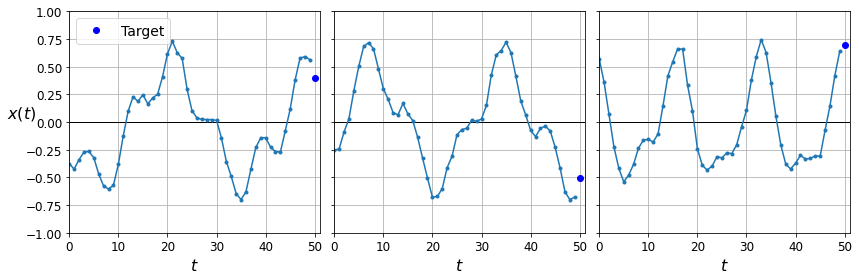

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

## 15.3.1 기준 성능

순진한 예측(naive forecasting) : 각 시계열의 마지막 값을 그대로 예측하는 경우, MSE는 매우 낮게 나타나지만 예측이 아님.

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

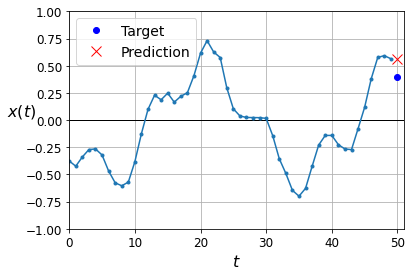

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# 선형 예측

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

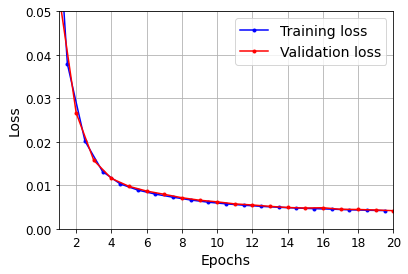

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


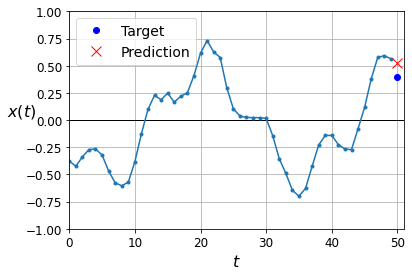

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.2 간단한 RNN 구현하기

순환 신경망은 어떤 길이의 타임스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없음(그래서 input shape의 첫번째 값이 None)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 31ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0116 - val_lo

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010881561785936356

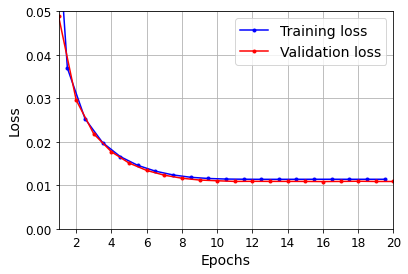

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


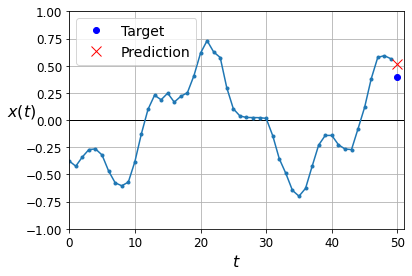

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

SimpleRNN으로 순진한 예측보다는 좋은 성능 기록, 하지만 선형모델보단 안좋음

그 이유는 선형모델은 51개의 하이퍼파라미터가 있고, RNN은 입력과 은닉 + 차원으로 3개의 파라미터 존재

시계열 자료에서는 트렌드와 계절성을 제거해야함

계절성은 매 타임 스텝의 값과 직전 계절(작년 3분기 등)의 차이를 계산하여 사용

RNN은 이러한 작업이 일반적으로는 필요 없다!

## 15.3.3 심층 RNN

심층 RNN은 순환층을 쌓으면 됨. SimpleRNN, LSTM, GRU 층 등을 쌓기

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 30s 126ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 33s 149ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 34s 157ms/step - l

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105606954544783

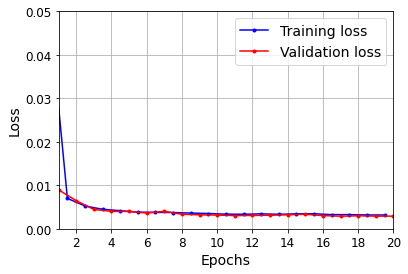

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 12ms/step


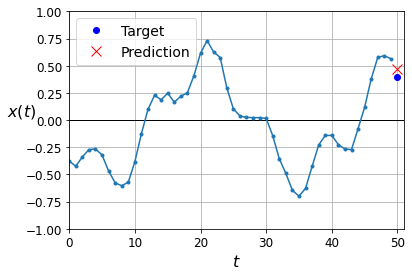

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

하지만 위의 모델에서 마지막 층은 이상적이지 않음. 단변량 시계열을 예측하기 때문에 하나의 유닛이 필요하고, 

그래서 마지막 층의 은닉 상태는 크게 필요하지 않다. 

그렇기 때문에 출력층은 일반적으로 Dense 층으로 바꾸어놓는 경우가 빈번

출력층을 Dense 층으로 놓기 때문에 출력층 이전층(2번째 층)의 return_sequences=True 인자는 제거

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 24s 104ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 29s 133ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0026


0.0026236241683363914

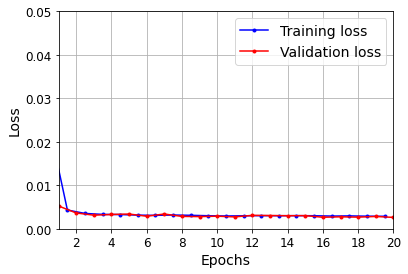

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 8ms/step


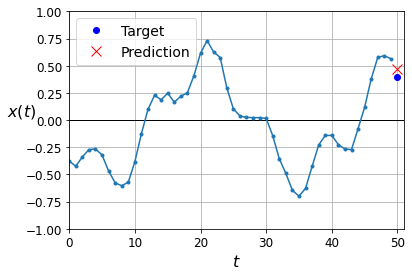

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.4 여러 타임 스텝 앞을 예측하기

만약 바로 다음 스텝이 아니라 여러 스텝 앞의 값으로 타깃을 바꾼다면? 

(10 스텝 앞의 값이 아니라, 10 스텝 앞까지 총 10개 스텝의 값을 예측)

1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 다시 입력으로 추가

In [11]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 100ms/step


In [12]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


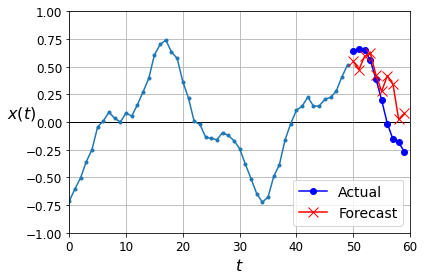

In [15]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [16]:
np.random.seed(42)

n_steps = 50

series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [17]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 10ms/step


In [18]:
Y_pred.shape

(2000, 10)

In [19]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.19622616

In [20]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [21]:
# 10개의 출력층이 필요한 모델

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [22]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 74ms/step - loss: 0.0502 - val_loss: 0.0265
Epoch 2/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 3/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 4/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 5/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 8/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 9/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 10/20
219/219 [==============================] - 23s 107ms/step - loss: 0.01

In [23]:
Y_pred = model.predict(X_new)

1/1 [==============================] - 0s 213ms/step


이 모델을 잘 작동. 다음 10개 타임스텝에 대한 MSE는 약 0.008

하지만 아직 개선의 여지가 있음. seq2vec 모델인 현재 모델에서 seq2seq으로 바꾸면 모델을 보다 안정적으로 만들고 훈련속도를 높일 수 있다.

seq2seq으로 바꾸려면 모든 순환층에 return_sequences=True를 지정해주어야함

그런 다음 모든 타임스텝에서 출력을 Dense층에 적용해야 하는데, 이런 기능을 TimeDistributed가 담당

In [24]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [25]:
# TimeDistributed 층은 다른 층을 감싸서 입력 시퀀스의 모든 타임스텝에 이를 적용
# 이를 통해 Dense 층이 실제로 시퀀스를 입력으로 받을 수 있고, 모든 타임스텝에 걸쳐 독립적으로 마지막 입력차원에만 적용

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [26]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 75ms/step - loss: 0.0538 - last_time_step_mse: 0.0434 - val_loss: 0.0409 - val_last_time_step_mse: 0.0294
Epoch 2/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0384 - last_time_step_mse: 0.0262 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0327 - last_time_step_mse: 0.0198 - val_loss: 0.0324 - val_last_time_step_mse: 0.0187
Epoch 4/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0298 - last_time_step_mse: 0.0173 - val_loss: 0.0278 - val_last_time_step_mse: 0.0163
Epoch 5/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0272 - last_time_step_mse: 0.0154 - val_loss: 0.0272 - val_last_time_step_mse: 0.0165
Epoch 6/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0265 - last_time_step_mse: 0.0151 - val_loss: 0.0253 - val_last_time_step_mse: 0.0132
Epoch 7/20
219/2

In [27]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 201ms/step


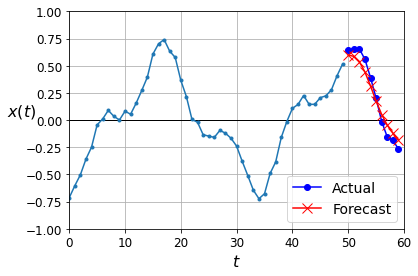

In [28]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 배치정규화를 이용한 심층RNN

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 20s 83ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/

# 15.4 긴 시퀀스 다루기

긴 시퀀스로 RNN을 훈련하려면 많은 타임스텝에 걸쳐 실행해야 하므로 RNN이 매우 깊은 네트워크가 됨. 

즉 Gradient Vanishing / Exploding 문제가 발생할 수 있음.

또한 훈련하는데 아주 오랜시간이 걸리거나 불안정할 수 있으며, 입력의 첫 부분을 조금씩 잊어버리는 문제가 발생

## 15.4.1 불안정한 Gradient 문제와 싸우기

불안정한 Gradient 문제를 해결하기 위해 심층신경망에 사용했던 (좋은) 가중치 초기화, 빠른 옵티마이저, 드롭아웃 등을 사용할 수 있음

그러나 수렴하지 않는 활성화 함수(ReLU)는 그라디언트가 폭주/소실되는 문제가 발생할 수 있음

배치 정규화는 심층 Feed-Forward 네트워크처럼 RNN에 효율적으로 사용할 수 없음

RNN에서 잘 맞는 다른 종류의 정규화는 층 정규화(layer normalization).

배치 정규화와 매우 비슷하지만 배치 차원에 대해 정규화하는 대신 특성 차원에 대해 정규화 진행

입력마다 하나의 스케일과 이동 파라미터를 학습

In [30]:
from tensorflow.keras.layers import LayerNormalization

In [32]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

state_size와 output_size 속성을 설정한 다음 활성화함수 없이 SimpleRNNCell을 생성

그 다음 생성자는 LayerNormalization 층을 만들고 마지막으로 원하는 활성화 함수를 선택



In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 62s 261ms/step - loss: 0.1588 - last_time_step_mse: 0.1550 - val_loss: 0.0730 - val_last_time_step_mse: 0.0662
Epoch 2/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0639 - last_time_step_mse: 0.0545 - val_loss: 0.0572 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0537 - last_time_step_mse: 0.0427 - val_loss: 0.0503 - val_last_time_step_mse: 0.0383
Epoch 4/20
219/219 [==============================] - 36s 164ms/step - loss: 0.0479 - last_time_step_mse: 0.0363 - val_loss: 0.0455 - val_last_time_step_mse: 0.0341
Epoch 5/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0438 - last_time_step_mse: 0.0321 - val_loss: 0.0422 - val_last_time_step_mse: 0.0301
Epoch 6/20
219/219 [==============================] - 44s 202ms/step - loss: 0.0404 - last_time_step_mse: 0.0292 - val_loss: 0.0383 - val_last_time_step_mse: 0.0264
Epoch 7/20

### 사용자 정의 RNN 클래스 만들기

In [34]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 40s 177ms/step - loss: 0.1591 - last_time_step_mse: 0.1557 - val_loss: 0.0735 - val_last_time_step_mse: 0.0669
Epoch 2/20
219/219 [==============================] - 49s 224ms/step - loss: 0.0650 - last_time_step_mse: 0.0550 - val_loss: 0.0581 - val_last_time_step_mse: 0.0441
Epoch 3/20
219/219 [==============================] - 40s 184ms/step - loss: 0.0538 - last_time_step_mse: 0.0405 - val_loss: 0.0494 - val_last_time_step_mse: 0.0366
Epoch 4/20
219/219 [==============================] - 38s 171ms/step - loss: 0.0472 - last_time_step_mse: 0.0353 - val_loss: 0.0442 - val_last_time_step_mse: 0.0322
Epoch 5/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0427 - last_time_step_mse: 0.0310 - val_loss: 0.0407 - val_last_time_step_mse: 0.0279
Epoch 6/20
219/219 [==============================] - 42s 191ms/step - loss: 0.0389 - last_time_step_mse: 0.0267 - val_loss: 0.0366 - val_last_time_step_mse: 0.0245
Epoch 7/20

## 15.4.2 단기 기억 문제 해결하기

RNN을 거치면서 어느 정도의 시간을 지나면 RNN의 상태는 사실상 첫번째 입력의 흔적을 가지고 있지 않음

이러한 문제를 해결하기 위해 장기 메모리를 가진 여러 종류의 셀이 연구 -> LSTM

### LSTM 셀

t번째 타임스텝에서, hidden state($h_{(t)}$)와 cell state($c_{(t)}$)가 존재.

이중에 hidden state가 단기기억, cell state가 장기기억 역할을 맡음

이전 스텝의 장기기억($c_{(t-1)}$)은 네트워크를 왼쪽에서 오른쪽으로 관통하면서, 삭제 게이트를 지나 일부 기억을 잃고, 입력 게이트에서 새로운 기억 일부를 추가하며, 이 결과가 출력 게이트에 의해 걸러지면서 단기 기억($h_{(t)}$)로 저장됨

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 17ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [37]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788686841726303, 0.008560805581510067]

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

NameError: ignored

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 핍홀 연결
- 이전 장기기억 상태가 삭제 게이트와 입력 게이트의 제어기에 입력으로 추가.
- 현재의 장기기억 상태는 출력 게이트의 제어기에 입력으로 추가


### GRU 셀

Gated Recurrent Unit(GRU : 게이트 순환 유닛)

GRU는 LSTM의 간소화된 버전

- 두 상태 벡터가 하나의 벡터 $h_{(t)}$로 합쳐짐
- 하나의 게이트 제어기가 삭제게이트와 입력게이트를 모두 제어. 게이트 제어기가 1을 출력하면 삭제게이트가 열리고, 입력게이트가 닫힘. 0을 출력하면 그 반대
- 다시 말해 기억이 저장될 때마다 저장될 위치에 있는 기억이 먼저 삭제
- 출력 게이트가 없음. 전체 상태벡터가 매 타임스텝마다 출력

LSTM과 GRU셀은 단순 RNN보다 훨씬 긴 시퀀스를 다룰 수 있지만 매우 제한적인 단기기억을 가짐. 100 타임스텝 이상의 시퀀스에서 장기 패턴을 학습하는데 어려움 존재 -> 1D 합성곱 층을 사용해 입력 시퀀스를 짧게 줄임

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 13ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=====

In [40]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.0102628068998456]

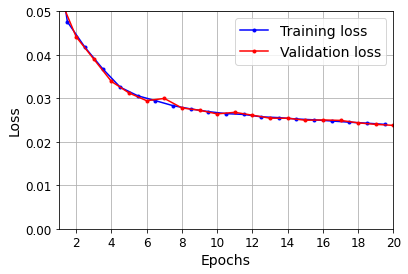

In [43]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [44]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 548ms/step


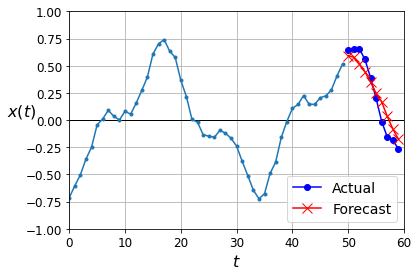

In [45]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 1D 합성곱 층을 사용해 시퀀스 처리하기

2D 합성곱 층이 이미지 데이터에 대해 몇 개의 작은 커널(필터)가 슬라이딩하여 (커널마다 하나씩) 2D 특성맵을 만든다는 것을 봄

비슷하게 1D 합성곱 층이 몇 개의 커널로 시퀀스 위를 슬라이딩하여 커널마다 1D 특성맵을 출력.

각 커널은 매우 짧은 하나의 순차패턴을 감지하도록 학습

스트라이드 1과 'same' 패딩으로 1D 합성곱 층을 사용하면 출력 시퀀스의 길이는 입력 시퀀스와 같음



In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data = (X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 9s 10ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=======

### WAVENET

층마다 팽창비율(각 뉴런의 입력이 떨어져 있는 간격)을 두배로 늘리는 1D 합성곱층을 쌓음.

- 첫번째 층은 2개의 타임스텝만 바라보고, 다음 층은 4개의 타임스텝을 보고, 다음은 8개를 보는 식으로 늘림
- 이런 방법을 통해 하위층은 단기패턴을 학습하고 상위층은 장기패턴을 학습
- WaveNet 논문에서는 1, 2, ... , 512까지의 합성곱 층 10개를 쌓음

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))

model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 8ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0239 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [========

- 'causal' 패딩 : 합성곱 층이 예측을 만들 때 미래의 시퀀스를 훔쳐보지 않는다.(즉 왼쪽에 0을 크기에 맞게 패딩하고 'valid' 패딩을 사용하는 것과 동일)

- 팽창 비율 1, 2, 4, 8의 층을 추가하고 다시 팽창비율 1, 2, 4, 8인 층을 추가하는 방식

- 출력층은 크기가 1인 필터 10개를 사용하고 활성화 함수가 없는 합성곱층
- 층에 추가한 패딩 덕분에 모든 합성곱 층은 입력 시퀀스의 길이와 동일한 시퀀스를 출력

- dilation_rate는 convolution 커널간의 간격을 의미. 즉 스트라이드와 유사개념

다음은 논문에 정의된 원본 WaveNet입니다: ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용합니다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩합니다:

In [48]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [49]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [51]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 4s 12ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 2s 10ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
